In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_cifar10_loaders(batch_size, partial=None, random=None):
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  
  if random is not None:
    np.random.seed(12345)
    temp = np.random.randint(10, size=len(trainset))
    trainset.targets = [int(label) for label in temp]
  if partial is not None:
    indices = np.arange(0,len(trainset))
    np.random.seed(12345)
    np.random.shuffle(indices)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(indices[:partial]))
  else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)
  return trainloader, testloader

Files already downloaded and verified
Files already downloaded and verified


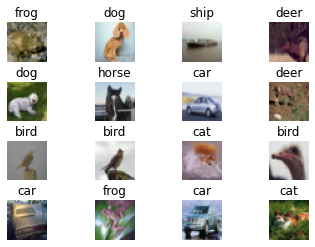

In [3]:
trainloader, _ = get_cifar10_loaders(256)

dataiter = iter(trainloader)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
S = 4

for i in range(S):
  for j in range(S):
    images, labels = dataiter.next()
    X = np.transpose(images[0].numpy()/2+0.5, (1, 2, 0))
    y = labels[0]

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(classes[y])
    plt.subplots_adjust(hspace = 0.5)

plt.show()

In [4]:
from sklearn.feature_extraction import image

batch = next(iter(trainloader))[0]
item = batch[0]
print(item.size())
item = item.permute(1,2,0)
print(item.size())

patches = image.extract_patches_2d(item, (16, 16))
print('Patches shape: {}'.format(patches.shape))
patches = torch.from_numpy(patches)
patches = patches.permute(0,3,1,2)

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])
Patches shape: (289, 16, 16, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


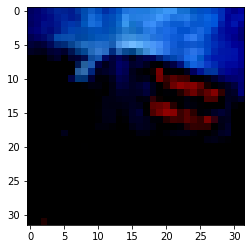

In [5]:
X = np.transpose(item.numpy()/2+0.5, (0, 1, 2))
plt.imshow(item.numpy())

torch.Size([3, 16, 16])
(16, 16, 3)


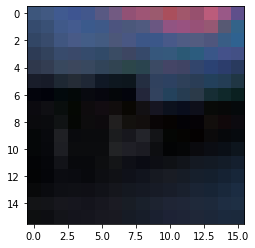

In [6]:
print(patches[0].size())
X = np.transpose(patches[285].numpy()/2+0.5, (1, 2, 0))
print(X.shape)
plt.imshow(X)

In [7]:
from sklearn.feature_extraction import image

def create_patches_data(trainloader, patch_size):
  # 32x32 images in CIFAR10, stride is 1
  num_patches_per_image = ((32 - patch_size + 1)**2)
  # 3 channels  
  flattened_patches_length = (patch_size**2) * 3
  data_matrix = None
  batch = 1
  patches_list = []
  for data in trainloader:
    inputs, labels = data
    for i in range(len(inputs)):
      img = inputs[i]
      img = img.permute(1,2,0)
      patches = image.extract_patches_2d(img, (patch_size, patch_size))
      patches_list.append(patches)
    batch+=1
  patches_list = np.stack(patches_list, axis=0)
  print(patches_list.shape)
  data_matrix = np.reshape(patches_list, (-1, flattened_patches_length))
  print(data_matrix.shape)
  return data_matrix


In [8]:
from numpy import linalg as LA

def create_eigs(data):
  cov_matrix = np.cov(data , rowvar=False)
  w, v = LA.eig(cov_matrix)
  return w,v

patch_size = 3
trainloader, _ = get_cifar10_loaders(256, partial=30000)
patches_data = create_patches_data(trainloader, patch_size)
eig_vals, eig_vecs = create_eigs(patches_data)

Files already downloaded and verified
Files already downloaded and verified
(30000, 900, 3, 3, 3)
(27000000, 27)


In [9]:
from torch import nn
import math

class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    
    self.conv = nn.Conv2d(in_channels=3, out_channels=256, 
                        kernel_size=3, stride=1, padding=0)
    last_size = 30*30*256
    self.fc = nn.Linear(last_size, 64)
    self.classifier = nn.Linear(64, 10)

  def forward(self, x):
    forward = nn.Sequential(self.conv, nn.ReLU(),
                            nn.Flatten(),
                            self.fc, nn.ReLU(),
                            self.classifier)
    x = forward(x)
    return x

In [35]:
from scipy.stats import ortho_group
np.random.seed(seed=12345)
random_basis = ortho_group.rvs(27)

In [37]:
from numpy.linalg import multi_dot
from numpy.linalg import inv

def calculate_misalignment(data_eig_vecs, weights):
  weights = np.reshape(weights, (weights.shape[0], -1))
  cov_weights = np.cov(weights , rowvar=False)
  res = 0
  for i in range(data_eig_vecs.shape[0]):
    a = multi_dot([data_eig_vecs[:,i].T, cov_weights, data_eig_vecs[:,i]])
    b = multi_dot([data_eig_vecs[:,i].T, inv(cov_weights), data_eig_vecs[:,i]])
    res += np.sqrt(a*b) - 1
  return res

def train(model, criterion, optimizer, epochs, dataloader, device, scheduler=None, verbose=True):
  loss_history = []
  misalignments_real = []
  misalignments_random = []
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):     
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)

      loss = criterion(outputs.to(device), labels)

      loss.backward()

      optimizer.step()

      loss_history.append(loss.item())

      weights = torch.clone(model.conv.weight).detach().numpy()
      misalignments_real.append(calculate_misalignment(eig_vecs, weights))
      weights = torch.clone(model.conv.weight).detach().numpy()
      misalignments_random.append(calculate_misalignment(random_basis, weights))

    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

    if scheduler is not None:
      scheduler.step()
      print('Epoch:', epoch,'LR:', scheduler.get_last_lr())

  return loss_history, misalignments_real, misalignments_random


In [38]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def get_training_components(learnable_params, init_lr, step_size=None, gamma=None):
  '''
  Function to prepare components of the training. These are all the same
  throughout the experiments made.
  '''
  # The problem always be a image classification
  criterion = nn.CrossEntropyLoss()
  # Which parameters to be updated depends on if the training is done from scratch
  # or with pre-trained model.
  optimizer = optim.SGD(learnable_params, lr=init_lr, momentum=0.9)
  # Step size depends on the # of epoch
  if step_size is not None:
    scheduler = StepLR(optimizer, step_size, gamma)
    return (criterion, optimizer, scheduler)
  return (criterion, optimizer)

def get_device():
  if torch.cuda.is_available():
    print("Cuda (GPU support) is available and enabled!")
    device = torch.device("cuda")
  else:
    print("Cuda (GPU support) is not available :(")
    device = torch.device("cpu")

def get_learnable_parameters(model):
  params_to_update = []
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
  return params_to_update


In [43]:
# Misalignment between data and random-label-trained filters
from torch import linalg as LA

simple_cnn = SimpleCNN()

trainloader, _ = get_cifar10_loaders(256, random=True)
device = get_device()
simple_cnn = simple_cnn.to(device)
simple_cnn.train()
epochs=40

learning_rate = 0.01

learnable_parameters = get_learnable_parameters(simple_cnn)
criterion, optimizer, scheduler = get_training_components(learnable_parameters, learning_rate, step_size=(int)(epochs/3), gamma=1/3)
loss_history, mis_eig_random_labels, mis_random_basis_random_labels = train(simple_cnn, criterion, optimizer, epochs, trainloader, device, scheduler=scheduler)

Files already downloaded and verified
Files already downloaded and verified
Cuda (GPU support) is available and enabled!
Epoch 0 / 40: avg. loss of last 5 iterations 2.3036006450653077
Epoch: 0 LR: [0.01]
Epoch 1 / 40: avg. loss of last 5 iterations 2.3031981945037843
Epoch: 1 LR: [0.01]
Epoch 2 / 40: avg. loss of last 5 iterations 2.302829456329346
Epoch: 2 LR: [0.01]
Epoch 3 / 40: avg. loss of last 5 iterations 2.302351379394531
Epoch: 3 LR: [0.01]
Epoch 4 / 40: avg. loss of last 5 iterations 2.3028821468353273
Epoch: 4 LR: [0.01]
Epoch 5 / 40: avg. loss of last 5 iterations 2.303126668930054
Epoch: 5 LR: [0.01]
Epoch 6 / 40: avg. loss of last 5 iterations 2.3033594131469726
Epoch: 6 LR: [0.01]
Epoch 7 / 40: avg. loss of last 5 iterations 2.3033597469329834
Epoch: 7 LR: [0.01]
Epoch 8 / 40: avg. loss of last 5 iterations 2.30306077003479
Epoch: 8 LR: [0.01]
Epoch 9 / 40: avg. loss of last 5 iterations 2.302907705307007
Epoch: 9 LR: [0.01]
Epoch 10 / 40: avg. loss of last 5 iterations

In [44]:
# Misalignment between data and real-label-trained filters
simple_cnn = SimpleCNN()
trainloader, _ = get_cifar10_loaders(256)

device = get_device()
simple_cnn = simple_cnn.to(device)
simple_cnn.train()
epochs=40
learning_rate = 0.01

learnable_parameters = get_learnable_parameters(simple_cnn)
criterion, optimizer, scheduler = get_training_components(learnable_parameters, learning_rate, step_size=(int)(epochs/3), gamma=1/3)
loss_history, mis_eig_real_labels, mis_random_basis_real_labels = train(simple_cnn, criterion, optimizer, epochs, trainloader, device, scheduler=scheduler)

Files already downloaded and verified
Files already downloaded and verified
Cuda (GPU support) is available and enabled!
Epoch 0 / 40: avg. loss of last 5 iterations 1.4103570938110352
Epoch: 0 LR: [0.01]
Epoch 1 / 40: avg. loss of last 5 iterations 1.1578023433685303
Epoch: 1 LR: [0.01]
Epoch 2 / 40: avg. loss of last 5 iterations 1.1308393478393555
Epoch: 2 LR: [0.01]
Epoch 3 / 40: avg. loss of last 5 iterations 1.028451955318451
Epoch: 3 LR: [0.01]
Epoch 4 / 40: avg. loss of last 5 iterations 0.8957690000534058
Epoch: 4 LR: [0.01]
Epoch 5 / 40: avg. loss of last 5 iterations 0.7533637762069703
Epoch: 5 LR: [0.01]
Epoch 6 / 40: avg. loss of last 5 iterations 0.7170258641242981
Epoch: 6 LR: [0.01]
Epoch 7 / 40: avg. loss of last 5 iterations 0.5928933024406433
Epoch: 7 LR: [0.01]
Epoch 8 / 40: avg. loss of last 5 iterations 0.5709020018577575
Epoch: 8 LR: [0.01]
Epoch 9 / 40: avg. loss of last 5 iterations 0.4808271169662476
Epoch: 9 LR: [0.01]
Epoch 10 / 40: avg. loss of last 5 itera

7840


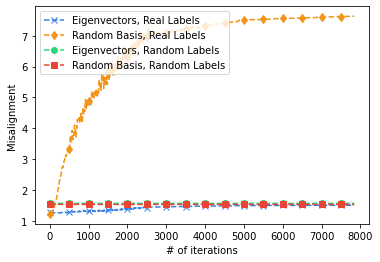

In [45]:
import matplotlib.pyplot as plt # For plotting
%matplotlib inline

print(len(mis_eig_real_labels))

marker_points = list(range(0, len(mis_eig_real_labels),500))

plt.plot(mis_eig_real_labels, linestyle='--', marker='x', color="#3980E4", markevery=marker_points)
plt.plot(mis_random_basis_real_labels, linestyle='--', marker='d', color="#F19418", markevery=marker_points)

plt.plot(mis_eig_random_labels, linestyle='--', marker='o', color="#2CD779", markevery=marker_points)


plt.plot(mis_random_basis_random_labels, linestyle='--', marker='s', color="#E94436", markevery=marker_points)

plt.legend(["Eigenvectors, Real Labels", "Random Basis, Real Labels",
            "Eigenvectors, Random Labels", "Random Basis, Random Labels"], loc ="upper left")
plt.xlabel('# of iterations')
plt.ylabel('Misalignment')
plt.show()

In [50]:
# Misalignment between data and random-label-trained filters
from torch import linalg as LA

simple_cnn = SimpleCNN()
trainloader, _ = get_cifar10_loaders(256, partial=1024*5, random=True)

device = get_device()
simple_cnn = simple_cnn.to(device)
simple_cnn.train()
epochs = 80
learning_rate = 0.01


learnable_parameters = get_learnable_parameters(simple_cnn)
criterion, optimizer, scheduler = get_training_components(learnable_parameters, learning_rate, step_size=(int)(epochs/3), gamma=1/3)
loss_history, mis_eig_random_labels, mis_random_basis_random_labels = train(simple_cnn, criterion, optimizer, epochs, trainloader, device, scheduler=scheduler)

Files already downloaded and verified
Files already downloaded and verified
Cuda (GPU support) is available and enabled!
Epoch 0 / 80: avg. loss of last 5 iterations 2.30920467376709
Epoch: 0 LR: [0.01]
Epoch 1 / 80: avg. loss of last 5 iterations 2.3003026485443114
Epoch: 1 LR: [0.01]
Epoch 2 / 80: avg. loss of last 5 iterations 2.2989768981933594
Epoch: 2 LR: [0.01]
Epoch 3 / 80: avg. loss of last 5 iterations 2.287828826904297
Epoch: 3 LR: [0.01]
Epoch 4 / 80: avg. loss of last 5 iterations 2.2739795684814452
Epoch: 4 LR: [0.01]
Epoch 5 / 80: avg. loss of last 5 iterations 2.248751926422119
Epoch: 5 LR: [0.01]
Epoch 6 / 80: avg. loss of last 5 iterations 2.2595921039581297
Epoch: 6 LR: [0.01]
Epoch 7 / 80: avg. loss of last 5 iterations 2.2197391033172607
Epoch: 7 LR: [0.01]
Epoch 8 / 80: avg. loss of last 5 iterations 2.2243191242218017
Epoch: 8 LR: [0.01]
Epoch 9 / 80: avg. loss of last 5 iterations 2.2049937725067137
Epoch: 9 LR: [0.01]
Epoch 10 / 80: avg. loss of last 5 iteratio

In [55]:
# Misalignment between data and real-label-trained filters
simple_cnn = SimpleCNN()
trainloader, _ = get_cifar10_loaders(256, partial=1024*5)

device = get_device()
simple_cnn = simple_cnn.to(device)
simple_cnn.train()
epochs = 80
learning_rate = 0.01

learnable_parameters = get_learnable_parameters(simple_cnn)
criterion, optimizer, scheduler = get_training_components(learnable_parameters, learning_rate, step_size=(int)(epochs/3), gamma=1/3)
loss_history, mis_eig_real_labels, mis_random_basis_real_labels = train(simple_cnn, criterion, optimizer, epochs, trainloader, device, scheduler=scheduler)

Files already downloaded and verified
Files already downloaded and verified
Cuda (GPU support) is available and enabled!
Epoch 0 / 80: avg. loss of last 5 iterations 1.96878821849823
Epoch: 0 LR: [0.01]
Epoch 1 / 80: avg. loss of last 5 iterations 1.7416323900222779
Epoch: 1 LR: [0.01]
Epoch 2 / 80: avg. loss of last 5 iterations 1.538123655319214
Epoch: 2 LR: [0.01]
Epoch 3 / 80: avg. loss of last 5 iterations 1.4600642204284668
Epoch: 3 LR: [0.01]
Epoch 4 / 80: avg. loss of last 5 iterations 1.3829689264297484
Epoch: 4 LR: [0.01]
Epoch 5 / 80: avg. loss of last 5 iterations 1.31605966091156
Epoch: 5 LR: [0.01]
Epoch 6 / 80: avg. loss of last 5 iterations 1.1879485845565796
Epoch: 6 LR: [0.01]
Epoch 7 / 80: avg. loss of last 5 iterations 1.0927483081817626
Epoch: 7 LR: [0.01]
Epoch 8 / 80: avg. loss of last 5 iterations 0.9989456176757813
Epoch: 8 LR: [0.01]
Epoch 9 / 80: avg. loss of last 5 iterations 0.9529556274414063
Epoch: 9 LR: [0.01]
Epoch 10 / 80: avg. loss of last 5 iteration

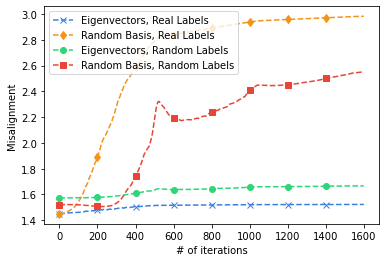

In [57]:
import matplotlib.pyplot as plt # For plotting
%matplotlib inline

marker_points = list(range(0, len(mis_eig_real_labels),200))

plt.plot(mis_eig_real_labels, linestyle='--', marker='x', color="#3980E4", markevery=marker_points)
plt.plot(mis_random_basis_real_labels, linestyle='--', marker='d', color="#F19418", markevery=marker_points)

plt.plot(mis_eig_random_labels, linestyle='--', marker='o', color="#2CD779", markevery=marker_points)


plt.plot(mis_random_basis_random_labels, linestyle='--', marker='s', color="#E94436", markevery=marker_points)

plt.legend(["Eigenvectors, Real Labels", "Random Basis, Real Labels",
            "Eigenvectors, Random Labels", "Random Basis, Random Labels"], loc ="upper left")
plt.xlabel('# of iterations')
plt.ylabel('Misalignment')
plt.show()